In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()

from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
spark = SparkSession.builder.getOrCreate()#create spark session 
sc = spark.sparkContext#create sparkContext
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                DecimalType,
                                LongType,
                                ArrayType,
                                TimestampType)

In [2]:
#Sensor Meta Data File Format
#The header line of the sensor meta data files is as follows:
#serial,latitude,longitude,height,type
#serial: the so called "serial number" of each sensor is a globally unique identifier for each sensor. 
#It can be used to join sensor meta information with measurement data.
#It is a signed integer and can therefore be negative.
#latitude/longitude/height: the three-dimensional location of the receiver.
#Latitude and longitude are in decimal degrees (WGS84), height is in meters.
#Note that this information is of varying/unknown accuracy since receiver locations are reported to the OpenSky Network in different ways.
#For sensors of type dump1090, these location are entered by the users themselves. 
#Most users use services such as Google Maps or their smart phones to determine the location of their antenna. 
#This process is prone to errors, but errors should usually be in the range of meters.
#Other users report wrong locations intentionally to masquerade their exact location for privacy reasons. 
#In this case, locations might be off by several kilometers. 
#For sensors of types Radarcape or GRX1090 the locations should generally be more accurate since they are automatically reported by the integrated GPS receivers and the GPS antenna is usually located close to the ADS-B antenna.
#type: the type of the receiver setup. The OpenSky Network currently supports sensors based on the open-source Mode S software decoder dump1090 and the commercial off-the-shelf devices Radarcape, SBS-3, and GRX1090.
#The device type also determines the measurement noise distribution and timestamp accuracy. However, note that these things also depend on many other factors (e.g., temperature, inside/outdoor deployment, ...).
sensors_schema = StructType([StructField("serial", LongType(), True),
                            StructField("latitudes", DoubleType(), True ),
                            StructField("longitudes",DoubleType(), True),
                            StructField("height",DoubleType(), True),
                            StructField("type", StringType(), True)
                            ])


#Column descriptions

#1*serial: unique sensor ID which can be used to join the sensor information with the measurements data.
#2*latitude: latitude of the sensor in decimal degrees. 
# It has been reported either by the sensor hardware or manually by the sensor operator.
#3*longitude: longitude of the sensor in decimal degrees.
#It has been reported either by the sensor hardware or manually by the sensor operator.
#4*height: height of the sensor in meters.
#Is has been reported either by the sensor hardware or manually by the sensor operator.
#5*type: type of the sensor hardware that was used to record the measurements.



sensors = spark.read.csv("C:/PFE/TEST/sensors.csv",
                       header = True, 
                        schema = sensors_schema)

sensors.show(5)
sensors.printSchema()

+------+-----------+----------+--------+--------+
|serial|  latitudes|longitudes|  height|    type|
+------+-----------+----------+--------+--------+
|     1|46.68106661|7.66531348|680.9232|   SBS-3|
|     2|  40.337042| -3.770206|735.7872|   SBS-3|
|     3|        0.0|       0.0|     0.0|   SBS-3|
|     4|  47.143056|  7.243889| 550.164|   SBS-3|
|     5|  52.356455|  4.952216|     0.0|dump1090|
+------+-----------+----------+--------+--------+
only showing top 5 rows

root
 |-- serial: long (nullable = true)
 |-- latitudes: double (nullable = true)
 |-- longitudes: double (nullable = true)
 |-- height: double (nullable = true)
 |-- type: string (nullable = true)



In [3]:
sensors.describe().show()

+-------+-----------------+-----------------+-----------------+------------------+--------+
|summary|           serial|        latitudes|       longitudes|            height|    type|
+-------+-----------------+-----------------+-----------------+------------------+--------+
|  count|              523|              523|              523|               523|     523|
|   mean|            262.0|47.97222843674732|6.560809878506962|238.34722259655823|    null|
| stddev|151.1213640312536|10.87344891475538| 7.46616980110261|  339.566869752558|    null|
|    min|                1|       -84.139365|       -21.955715|         -1.820427|    Aero|
|    max|              523|          67.2772|        24.833131|            4068.0|dump1090|
+-------+-----------------+-----------------+-----------------+------------------+--------+



In [ ]:
sensors.groupBy("type").count().show()

+---------+-----+
|     type|count|
+---------+-----+
|  Asterix|    1|
|     Aero|    1|
|    SBS-3|   14|
|  GRX1090|   10|
| dump1090|  416|
|Radarcape|   81|
+---------+-----+



In [ ]:
import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt
sensors1=sensors.groupBy("type").count()
sensors1=sensors1.orderBy('count')
#We can also use matplotlib and Pandas to visualize the total number of sens  by type  
import pandas as pd

%matplotlib inline
Sensors1_pandas_DataFrame = pd.DataFrame.from_records(sensors1.collect(), columns=sensors1.columns)
Sensors1_pandas_DataFrame.head(20)



,type,count
0,Asterix,1
1,Aero,1
2,GRX1090,10
3,SBS-3,14
4,Radarcape,81
5,dump1090,416


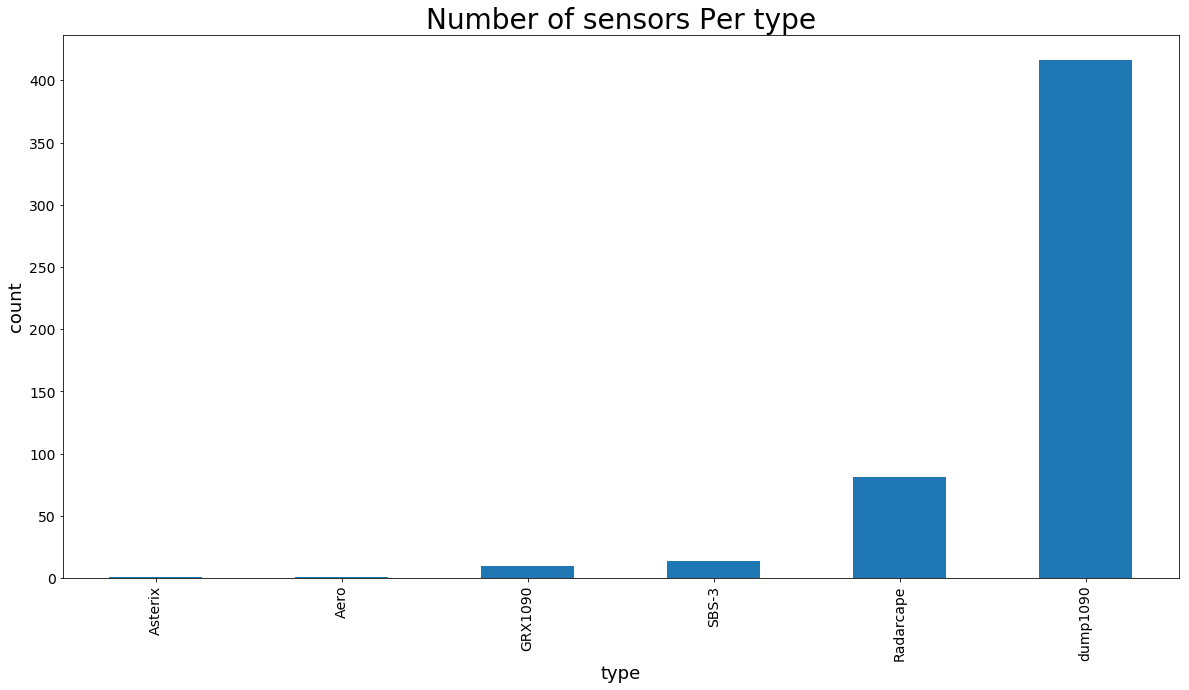

In [ ]:
Sensors1_pandas_DataFrame.plot(figsize = (20,10), kind = "bar",
                               x = "type", y = "count", legend = False)

plt.xlabel("type", fontsize = 18)
plt.ylabel("count", fontsize = 18)
plt.title("Number of sensors Per type", fontsize = 28)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [ ]:
#with this we can plot our aircraft points with airoprt data and sensor data 
import plotly.graph_objects as go
import plotly.io as pio

Sensors_pandas_DataFrame = pd.DataFrame.from_records(sensors.collect(), columns=sensors.columns)
Sensors_pandas_DataFrame['latitudes'] = pd.to_numeric(Sensors_pandas_DataFrame['latitudes'],errors='coerce')
Sensors_pandas_DataFrame['longitudes'] = pd.to_numeric(Sensors_pandas_DataFrame['longitudes'],errors='coerce')
Sensors_pandas_DataFrame['latitudes'] = Sensors_pandas_DataFrame['latitudes'].astype(float)
Sensors_pandas_DataFrame['longitudes'] = Sensors_pandas_DataFrame['longitudes'].astype(float)
Sensors_pandas_DataFrame.dropna()

fig = go.Figure(go.Scatter(x=Sensors_pandas_DataFrame['latitudes'], y=Sensors_pandas_DataFrame['longitudes'],text=Sensors_pandas_DataFrame.type, mode='markers', name='sensors localisation of all sensors'))

fig.update_xaxes(title_text='laltitude', type='log')
fig.update_yaxes(title_text='Longitude')
fig.update_layout(title_text='Sensors_Positions')

In [ ]:
#using plotly 
import plotly.offline as py
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import json


Sensors_pandas_DataFrame = [ dict(
        type = 'scattergeo',
        locationmode = 'ISO-3',
        lon = Sensors_pandas_DataFrame['longitudes'],
        lat =Sensors_pandas_DataFrame['latitudes'],
        hoverinfo = 'text',
        text = Sensors_pandas_DataFrame.type,
        mode = 'markers',
        marker = dict(
            size=3,
            color='rgb(255, 20, 147)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ) ,
      name='sensors localisation')]






layout = dict(
        margin = dict( t = 0, l = 0, r = 0, b = 0 ),
        showlegend = False,         
        geo = dict(
            showland = True,
            showlakes = True,
            showcountries = True,
            showocean = True,
            countrywidth = 0.5,
            landcolor = 'rgb(230, 145, 56)',
            lakecolor = 'rgb(0, 255, 255)',
            oceancolor = 'rgb(0, 255, 255)',
            projection = dict( 
                type = 'orthographic',
                rotation = dict(lon = 0, lat = 0, roll = 0 )            
            ),
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            )
        )
    )

sliders = []

lon_range = np.arange(-180, 180, 10)
lat_range = np.arange(-90, 90, 10)

sliders.append( 
    dict(
        active = len(lon_range)/2,
        currentvalue = {"prefix": "Longitude: "},
        pad = {"t": 0},
        steps = [{
                'method':'relayout', 
                'label':str(i),
                'args':['geo.projection.rotation.lon', i]} for i in lon_range]
    )      
)

sliders.append( 
    dict(
        active = len(lat_range)/2,
        currentvalue = {"prefix": "Latitude: "},
        pad = {"t": 100},
        steps = [{
                'method':'relayout', 
                'label':str(i),
                'args':['geo.projection.rotation.lat', i]} for i in lat_range]
    )      
)

projections = [ "equirectangular", "mercator", "orthographic", "natural earth","kavrayskiy7", 
               "miller", "robinson", "eckert4", "azimuthal equal area","azimuthal equidistant", 
               "conic equal area", "conic conformal", "conic equidistant", "gnomonic", "stereographic", 
               "mollweide", "hammer", "transverse mercator", "albers usa", "winkel tripel" ]

buttons = [ dict( args=['geo.projection.type', p], label=p, method='relayout' ) for p in projections ]

annot = list([ dict( x=0.1, y=0.8, text='Projection', yanchor='bottom', 
                    xref='paper', xanchor='right', showarrow=False )])

# Update Layout Object

layout[ 'updatemenus' ] = list([ dict( x=0.1, y=0.8, buttons=buttons, yanchor='top' )])

layout[ 'annotations' ] = annot

layout[ 'sliders' ] = sliders
fig = dict( data=Sensors_pandas_DataFrame, layout=layout )
py.iplot( fig)